<a href="https://colab.research.google.com/github/ZhexuanWang/AI-model-training/blob/master/VQGAN%2BPixelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 83.3MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth
📦 Epoch 1/100 - Loss: 4.6101
📦 Epoch 2/100 - Loss: 4.3739
📦 Epoch 3/100 - Loss: 4.2471
📦 Epoch 4/100 - Loss: 3.9961
📦 Epoch 5/100 - Loss: 3.8776
📦 Epoch 6/100 - Loss: 3.7823
📦 Epoch 7/100 - Loss: 3.7347
📦 Epoch 8/100 - Loss: 3.7334
📦 Epoch 9/100 - Loss: 3.5154


📦 Epoch 10/100 - Loss: 3.5048
💾 Saved decoder at epoch 10


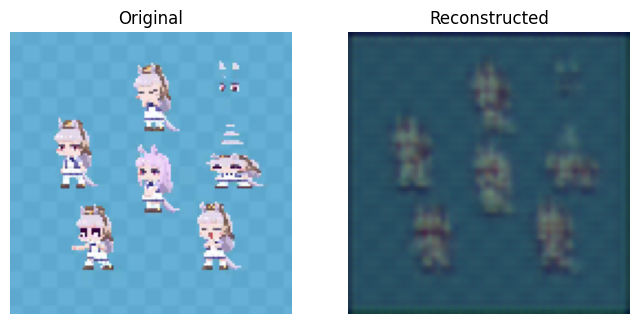

📦 Epoch 11/100 - Loss: 3.4441
📦 Epoch 12/100 - Loss: 3.4068
📦 Epoch 13/100 - Loss: 3.3723
📦 Epoch 14/100 - Loss: 3.4125
📦 Epoch 15/100 - Loss: 3.3463
📦 Epoch 16/100 - Loss: 3.2443
📦 Epoch 17/100 - Loss: 3.2073
📦 Epoch 18/100 - Loss: 3.2016
📦 Epoch 19/100 - Loss: 3.0785
📦 Epoch 20/100 - Loss: 2.9881
💾 Saved decoder at epoch 20


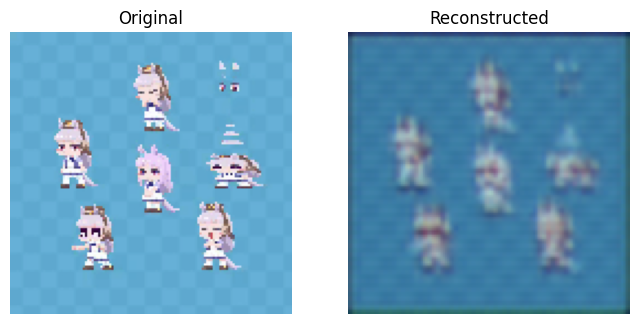

📦 Epoch 21/100 - Loss: 2.9364
📦 Epoch 22/100 - Loss: 2.9176
📦 Epoch 23/100 - Loss: 2.8526
📦 Epoch 24/100 - Loss: 2.8491
📦 Epoch 25/100 - Loss: 2.8331
📦 Epoch 26/100 - Loss: 2.8199
📦 Epoch 27/100 - Loss: 2.7305
📦 Epoch 28/100 - Loss: 2.7018
📦 Epoch 29/100 - Loss: 2.6460


📦 Epoch 30/100 - Loss: 2.5955
💾 Saved decoder at epoch 30


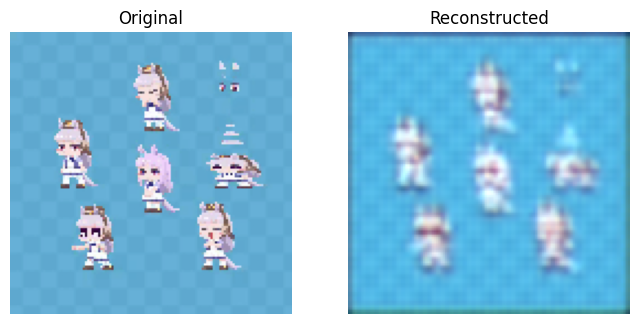

📦 Epoch 31/100 - Loss: 2.5808
📦 Epoch 32/100 - Loss: 2.5756
📦 Epoch 33/100 - Loss: 2.5681
📦 Epoch 34/100 - Loss: 2.5252
📦 Epoch 35/100 - Loss: 2.5002
📦 Epoch 36/100 - Loss: 2.4754
📦 Epoch 37/100 - Loss: 2.4742
📦 Epoch 38/100 - Loss: 2.4774


In [ ]:
# ✅ 导入库
import os
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Embedding
from pathlib import Path
import lpips
import matplotlib.pyplot as plt

# ✅ 设置数据路径（挂载 Google Drive 后）
dataset_path = "/content/drive/MyDrive/PixelArtDataset"

# ✅ 图像预处理（居中填充到正方形）
def pad_to_square(img, target_size=128):
    w, h = img.size
    max_side = max(w, h)
    new_img = Image.new("RGB", (max_side, max_side), (0, 0, 0))
    new_img.paste(img, ((max_side - w) // 2, (max_side - h) // 2))
    return new_img.resize((target_size, target_size), Image.NEAREST)

transform = transforms.Compose([
    transforms.ToTensor()
])

# ✅ 加载图像并记录尺寸
def load_images_and_sizes(root, use_padding=True, target_size=128):
    images = []
    size_records = []
    for subdir, _, files in os.walk(root):
        for file in files:
            if file.endswith(".png"):
                path = os.path.join(subdir, file)
                img = Image.open(path).convert("RGB")
                original_size = img.size
                size_records.append(original_size)
                if use_padding:
                    img = pad_to_square(img, target_size)
                images.append(transform(img))
    return torch.stack(images), size_records

# ✅ 构建尺寸嵌入
def build_size_embedding(size_records, embedding_dim=16):
    unique_sizes = sorted(set(size_records))
    size_to_index = {size: i for i, size in enumerate(unique_sizes)}
    embedding_layer = Embedding(len(unique_sizes), embedding_dim)
    return size_to_index, embedding_layer

# ✅ 加载数据
images, size_records = load_images_and_sizes(dataset_path)
size_to_index, size_embedding = build_size_embedding(size_records)
size_indices = [size_to_index[size] for size in size_records]
size_indices_tensor = torch.tensor(size_indices)

# ✅ 定义编码器（返回跳跃连接）
class SimpleEncoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, latent_dim, 1)

    def forward(self, x):
        x1 = F.relu(self.conv1(x)) # [B, 64, H/2, W/2]
        x2 = F.relu(self.conv2(x1)) # [B, 128, H/4, W/4]
        x3 = self.conv3(x2) # [B, 256, H/4, W/4]
        return x3, x2, x1

# ✅ 定义解码器（U-Net 风格）
class UNetDecoder(nn.Module):
    def __init__(self, latent_dim=272, out_channels=3):
        super().__init__()
        self.up1 = nn.ConvTranspose2d(latent_dim, 128, 4, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1)
        self.final = nn.Conv2d(64, out_channels, 1)

        # ✅ 新增细节残差模块
        self.refine = nn.Sequential(
            nn.Conv2d(out_channels, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, 1)
        )

    def forward(self, z, skip2, skip1):
        x = F.relu(self.up1(z))
        x = F.interpolate(x, size=skip2.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip2], dim=1)
        x = F.relu(self.up2(x))
        x = F.interpolate(x, size=skip1.shape[2:], mode='bilinear', align_corners=False)
        x = self.final(x)
        x = x + self.refine(x)  # ✅ 加入细节补偿
        return x


# ✅ 边缘损失函数（Sobel 算子）
def edge_loss(x, y):
    # Sobel 卷积核
    sobel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32).view(1, 1, 3, 3).to(x.device)
    sobel_y = sobel_x.transpose(2, 3)

    def gradient(img):
        B, C, H, W = img.shape
        grads_x = []
        grads_y = []
        for c in range(C):
            channel = img[:, c:c+1, :, :]  # [B, 1, H, W]
            gx = F.conv2d(channel, sobel_x, padding=1)
            gy = F.conv2d(channel, sobel_y, padding=1)
            grads_x.append(gx)
            grads_y.append(gy)
        grad_x = torch.cat(grads_x, dim=1)  # [B, C, H, W]
        grad_y = torch.cat(grads_y, dim=1)
        return grad_x, grad_y

    gx1, gy1 = gradient(x)
    gx2, gy2 = gradient(y)
    return F.l1_loss(gx1, gx2) + F.l1_loss(gy1, gy2)

# ✅ 固定调色板（示例：8色）
palette = torch.tensor([
    [0, 0, 0],
    [255, 255, 255],
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
    [255, 255, 0],
    [255, 0, 255],
    [0, 255, 255]
], dtype=torch.float32).to(device) / 255.0  # [8, 3]

def palette_loss(img):
    B, C, H, W = img.shape
    img_flat = img.permute(0, 2, 3, 1).reshape(-1, 3)  # [BHW, 3]
    dists = torch.cdist(img_flat, palette)  # [BHW, 8]
    min_dist = dists.min(dim=1)[0]
    return min_dist.mean()

# ✅ 初始化模型与损失函数
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder = SimpleEncoder().to(device)
decoder = UNetDecoder().to(device)

# ✅ 加载 encoder 权重（可选）
encoder.load_state_dict(torch.load("/content/drive/MyDrive/vqgan_encoder_optimized_3.pth", map_location=device))

# ✅ 冻结 encoder（方式二推荐）
for param in encoder.parameters():
    param.requires_grad = False

# ✅ 优化器只训练 decoder
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4)

# ✅ LPIPS 感知损失
loss_fn_lpips = lpips.LPIPS(net='vgg').to(device)

# ✅ 训练参数
epochs = 100
batch_size = 32

# ✅ 数据分批
def get_batches(images, size_indices, batch_size):
    for i in range(0, len(images), batch_size):
        yield images[i:i+batch_size], size_indices[i:i+batch_size]

# ✅ 可视化函数
def show_images(original, reconstructed):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(original.squeeze(0).permute(1, 2, 0).cpu())
    axs[0].set_title("Original")
    axs[0].axis("off")
    axs[1].imshow(reconstructed.squeeze(0).permute(1, 2, 0).cpu())
    axs[1].set_title("Reconstructed")
    axs[1].axis("off")
    plt.show()

# ✅ 主训练循环
for epoch in range(epochs):
    total_loss = 0
    decoder.train()
    for batch_imgs, batch_sizes in get_batches(images, size_indices_tensor, batch_size):
        batch_imgs = batch_imgs.to(device)
        batch_sizes = batch_sizes.to(device)

        # 编码器输出 latent + skip features
        with torch.no_grad():  # encoder 已冻结
            latent, skip2, skip1 = encoder(batch_imgs)

        # 尺寸嵌入扩展到 latent 空间维度
        H, W = latent.shape[2], latent.shape[3]
        size_vecs = size_embedding(batch_sizes).to(device).view(batch_imgs.size(0), -1, 1, 1).expand(-1, -1, H, W)

        # 条件融合
        latent_cond = torch.cat([latent, size_vecs], dim=1)

        # 解码器重建
        recon = decoder(latent_cond, skip2, skip1)

        # 损失计算
        recon_resized = F.interpolate(recon, size=batch_imgs.shape[2:], mode='bilinear', align_corners=False)
        loss_mse = F.mse_loss(recon_resized, batch_imgs)
        loss_lpips = loss_fn_lpips(recon_resized, batch_imgs).mean()
        loss_edge = edge_loss(recon_resized, batch_imgs)
        loss_palette = palette_loss(recon_resized)
        loss = loss_mse + 0.6 * loss_lpips + 0.3 * loss_edge + 0.3 * loss_palette

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"📦 Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")

    # ✅ 每 10 epoch 保存模型
    if (epoch + 1) % 10 == 0:
        torch.save(decoder.state_dict(), f"/content/drive/MyDrive/vqgan_decoder_refined_epoch{epoch+1}.pth")
        print(f"💾 Saved decoder at epoch {epoch+1}")

        # ✅ 可视化样例
        with torch.no_grad():
            sample_img = batch_imgs[0:1]
            sample_size = batch_sizes[0:1]
            latent, skip2, skip1 = encoder(sample_img)
            H, W = latent.shape[2], latent.shape[3]
            size_vec = size_embedding(sample_size).to(device).view(1, -1, 1, 1).expand(-1, -1, H, W)
            latent_cond = torch.cat([latent, size_vec], dim=1)
            recon = decoder(latent_cond, skip2, skip1)
            recon_resized = F.interpolate(recon, size=sample_img.shape[2:], mode='bilinear', align_corners=False)
            show_images(sample_img, recon_resized)

# ✅ 最终保存模型
torch.save(decoder.state_dict(), "/content/drive/MyDrive/vqgan_decoder_refined_final.pth")
print("✅ 模型训练完成并保存")



In [ ]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


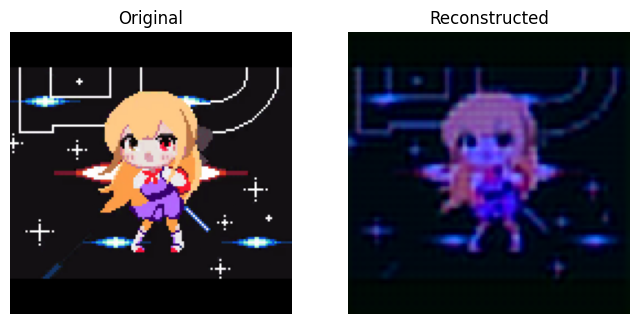

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# ✅ 模型结构（保持和训练一致）
class SimpleEncoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, latent_dim, 1)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        x3 = self.conv3(x2)
        return x3, x2, x1

class UNetDecoder(nn.Module):
    def __init__(self, latent_dim=272, out_channels=3):
        super().__init__()
        self.up1 = nn.ConvTranspose2d(latent_dim, 128, 4, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1)
        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, z, skip2, skip1):
        x = F.relu(self.up1(z))
        x = F.interpolate(x, size=skip2.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip2], dim=1)
        x = F.relu(self.up2(x))
        x = F.interpolate(x, size=skip1.shape[2:], mode='bilinear', align_corners=False)
        x = self.final(x)
        return x

# ✅ 初始化模型
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder = SimpleEncoder().to(device)
decoder = UNetDecoder().to(device)

# ✅ 加载权重
encoder.load_state_dict(torch.load("/content/drive/MyDrive/vqgan_encoder_optimized_3.pth", map_location=device))
decoder.load_state_dict(torch.load("/content/drive/MyDrive/vqgan_decoder_optimized_3.pth", map_location=device))
encoder.eval()
decoder.eval()

# ✅ 尺寸嵌入（保持一致）
size_embedding = nn.Embedding(100, 16).to(device)  # 假设最多100种尺寸
size_index = torch.tensor([0]).to(device)          # 示例尺寸索引

# ✅ 图像预处理
def preprocess(img_path, target_size=128):
    img = Image.open(img_path).convert("RGB")
    w, h = img.size
    max_side = max(w, h)
    padded = Image.new("RGB", (max_side, max_side), (0, 0, 0))
    padded.paste(img, ((max_side - w) // 2, (max_side - h) // 2))
    resized = padded.resize((target_size, target_size), Image.NEAREST)
    tensor = transforms.ToTensor()(resized).unsqueeze(0).to(device)
    return tensor

# ✅ 推理流程
img_path = "/content/drive/MyDrive/PixelArtDataset/动态1（500） (1)/动态1（500） (1)_frame000.png"  # 替换为你的图像路径
img_tensor = preprocess(img_path)
latent, skip2, skip1 = encoder(img_tensor)

# 拼接尺寸嵌入
H, W = latent.shape[2], latent.shape[3]
size_vec = size_embedding(size_index).view(1, -1, 1, 1).expand(-1, -1, H, W)
latent_cond = torch.cat([latent, size_vec], dim=1)

# 解码
with torch.no_grad():
    recon = decoder(latent_cond, skip2, skip1)
    recon_resized = F.interpolate(recon, size=img_tensor.shape[2:], mode='bilinear', align_corners=False)

# ✅ 显示原图与重建图像
def show_images(original, reconstructed):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(original.squeeze(0).permute(1, 2, 0).cpu())
    axs[0].set_title("Original")
    axs[0].axis("off")
    axs[1].imshow(reconstructed.squeeze(0).permute(1, 2, 0).cpu())
    axs[1].set_title("Reconstructed")
    axs[1].axis("off")
    plt.show()

show_images(img_tensor, recon_resized)
